In this notebook, we build a Machine Learning model on the digit recognizer based on the eigenvalue features.

In [1]:
%pylab inline
pylab.style.use('ggplot')

import numpy as np
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os

feature_file = os.path.join(os.getcwd(), 'char_features.csv')
data_df = pd.read_csv(feature_file, index_col=0)

In [3]:
data_df.describe().T

,count,mean,std,min,25%,50%,75%,max
nu03,1496.0,0.000046,0.000287,-0.001102,-0.000118,0.000024,0.000194,0.001627
nu11,1496.0,0.000031,0.000209,-0.001182,-0.000059,0.000018,0.000119,0.000932
nu12,1496.0,0.000249,0.000523,-0.001331,-0.000106,0.000192,0.000563,0.002311
on_pixel_frac,1496.0,0.040004,0.019563,0.001957,0.027081,0.038540,0.051335,0.104639
on_pixel_x_var,1496.0,8.071443,2.986408,0.187500,6.664485,8.583488,10.064963,15.352538
on_pixel_y_var,1496.0,6.324439,3.035991,0.000000,4.716589,6.572320,8.047325,26.270145
dct_0,1496.0,7857.911932,95.744775,7761.562500,7777.500000,7857.187500,7881.093750,8112.187500
dct_1,1496.0,-9.349362,31.128139,-96.483588,-8.651894,-5.434853,2.311168,29.736777
dct_2,1496.0,71.084518,166.104443,-206.684980,-52.205754,99.375435,220.018664,338.203586
dct_3,1496.0,344.807495,115.873211,40.305293,301.514885,377.801365,431.492843,470.849634


In [4]:
features = data_df.drop('font_name', axis=1)
np.isfinite(features).sum(axis=0)

nu03              1496
nu11              1496
nu12              1496
on_pixel_frac     1496
on_pixel_x_var    1496
on_pixel_y_var    1496
dct_0             1496
dct_1             1496
dct_2             1496
dct_3             1496
dct_4             1496
dct_5             1496
dtype: int64

# Instance Counts Per Class

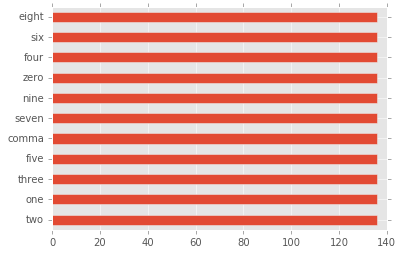

In [5]:
data_df.index.value_counts().plot(kind='barh')

In [6]:
# Negative Values Check
(features < 0).sum(axis=0)

nu03              677
nu11              647
nu12              555
on_pixel_frac       0
on_pixel_x_var      0
on_pixel_y_var      0
dct_0               0
dct_1             952
dct_2             680
dct_3               0
dct_4             952
dct_5             136
dtype: int64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

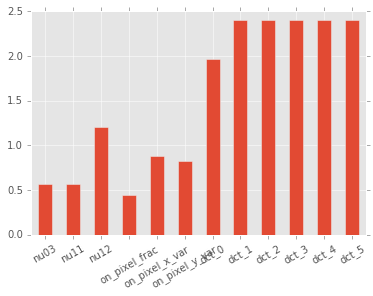

In [7]:
from sklearn.feature_selection import mutual_info_classif

f_importances = mutual_info_classif(features, features.index)
f_importances = pd.Series(f_importances, index=features.columns)

f_importances.plot(kind='bar')
pylab.xticks(rotation=30)

In [8]:
dct_cols = features.columns.str.startswith('dct')
features = features.loc[:, dct_cols]

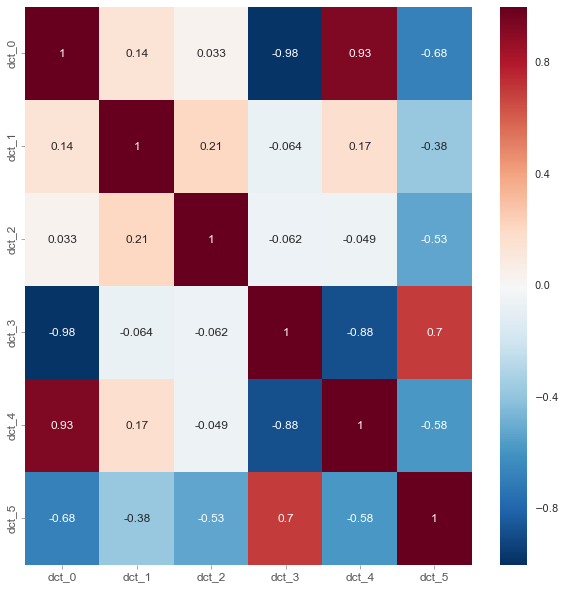

In [9]:
f_corrs = features.corr()

_, ax = pylab.subplots(1, 1, figsize=(10, 10))
import seaborn as sns
sns.heatmap(f_corrs, annot=True, ax=ax)

In [10]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline

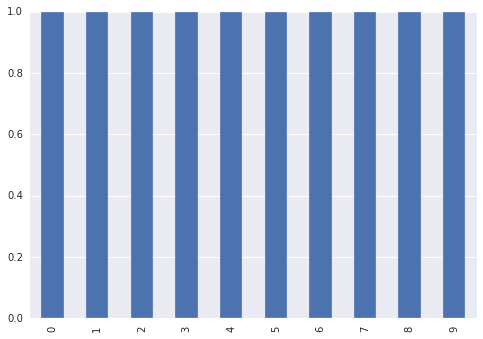

In [11]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

normalizer = StandardScaler()
estimator = SVC(C=5000)

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=12345)

pipeline = Pipeline([
    ('normalizer', normalizer),
    ('estimator', estimator),
])

scores = cross_val_score(pipeline, features, features.index, cv=cv, scoring='accuracy')

scores = pd.Series(scores)
scores.plot(kind='bar')

In [12]:
scores.mean()

1.0

In [13]:
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict

normalizer = StandardScaler()
estimator = SVC(C=5000)

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=12345)

pipeline = Pipeline([    
    ('normalizer', normalizer),
    ('estimator', estimator),
])

predictions = cross_val_predict(pipeline, features, features.index, cv=cv)

report = classification_report(y_true=data_df.index.values, y_pred=predictions)
print(report)

             precision    recall  f1-score   support

      comma       1.00      1.00      1.00       136
      eight       1.00      1.00      1.00       136
       five       1.00      1.00      1.00       136
       four       1.00      1.00      1.00       136
       nine       1.00      1.00      1.00       136
        one       1.00      1.00      1.00       136
      seven       1.00      1.00      1.00       136
        six       1.00      1.00      1.00       136
      three       1.00      1.00      1.00       136
        two       1.00      1.00      1.00       136
       zero       1.00      1.00      1.00       136

avg / total       1.00      1.00      1.00      1496



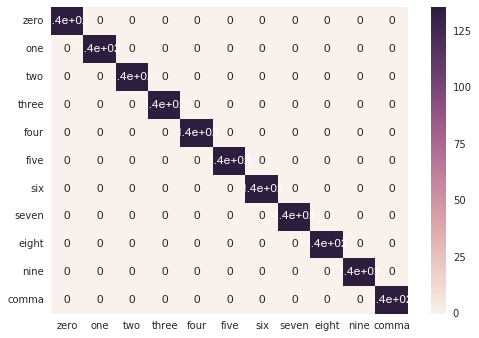

In [14]:
from sklearn.metrics import confusion_matrix

chars = pd.unique(data_df.index)

# Passing labels=char ensures that confusion_matrix orders the results in the the same order as chars
# This ensures our tick labels and the confusion matrix output are correctly aligned.
cm = confusion_matrix(data_df.index, predictions, labels=chars)
sns.heatmap(cm, annot=True, xticklabels=chars, yticklabels=chars)